In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('ggplot')
import torch
from torch.nn.functional import softmax
from scipy.special import softmax as np_softmax
from scipy.linalg import toeplitz, circulant
import numpy as np
from torch.autograd import Variable
from torch.distributions import uniform, cauchy, normal, relaxed_bernoulli
import matplotlib.animation as animation
from IPython.display import HTML
import time
import ipdb

In [2]:
def update_gif(i, im, data):
    im.set_array(data[i])
    return im,

def show_connectivities_gif(connectivities):
    im = plt.imshow(connectivities[0], animated=True)
    ani = animation.FuncAnimation(fig, update_gif, fargs=(im, connectivities))
    plt.show(block=False)

In [3]:
def sigmoid(x):
    return 1. / (1 + torch.exp(-1*(x)))

def normalize(x):
    return x / torch.sqrt((x**2).sum())

In [4]:
def make_connectivity(soft_connectivity):
    batch_size = soft_connectivity.shape[0]
    ut_size = soft_connectivity.shape[-1]
    num_units = int(.5*(np.sqrt(8*ut_size + 1) + 1))
    triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)

    connectivity = torch.zeros((batch_size, num_units, num_units))
    _, hard_inds = torch.topk(soft_connectivity,num_links, dim=-1)
    hard_connectivity = torch.zeros_like(soft_connectivity).scatter_(1,hard_inds, torch.ones_like(hard_inds).float())
    ut_connectivity = hard_connectivity - soft_connectivity.detach() + soft_connectivity

    connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
    connectivity += connectivity.transpose(2,1)
    return connectivity

In [5]:
# Fetch distribution objects for intrinsic frequencies

def get_dist(dist_name,):
    if dist_name == 'cauchy':
        loc = 0.0
        scale = 1.0
        dist = cauchy.Cauchy(loc, scale)
        g0 = torch.exp(dist.log_prob(loc))
        return dist, g0
    elif dist_name == 'uniform':
        high = 1.0
        low = -1.0
        g0 = 1. / (high - low)
        dist = uniform.Uniform(-1.0, 1.0)
        return dist, g0

In [6]:
def get_current_lr(optimizer):
    # Adam has different learning rates for each paramter. So we need to pick the
    # group and paramter first.
    lrs = []
    for group in optimizer.param_groups:
        for p in group['params']:
            beta1, _ = group['betas']
            state = optimizer.state[p]

            bias_correction1 = 1 - beta1 ** state['step']
            lrs.append(group['lr'] / bias_correction1)
    return lrs

In [ ]:
# Networks

# Predict connectivity from omega
class connectivity_net(torch.nn.Module):
    def __init__(self, num_in, num_out, num_hid_units=256, num_hid_layers=1,transform=None):
        super(connectivity_net, self).__init__()
        self.transform=transform
        self.num_out = num_out
        self.layers = torch.nn.ModuleList([torch.nn.Linear(num_in, num_hid_units),
                         torch.nn.ReLU()])
        for _ in range(num_hid_layers):
            self.layers.extend([torch.nn.Linear(num_hid_units, num_hid_units),torch.nn.ReLU()])
        self.layers.append(torch.nn.Linear(num_hid_units,self.num_out))
    def forward(self,x):   
        for layer in self.layers:
            x = layer(x)
        if self.transform == 'softmax':
            x = softmax(x,dim=-1)
        elif self.transform == 'sigmoid':
            x = sigmoid(x)
        return x
    
class connectivity_GRU(torch.nn.Module):
    def __init__(self, num_in, num_out, num_hid_units=256,num_hid_layers=1, T=10, transform=None):
        super(connectivity_GRU, self).__init__()
        self.num_out = num_out
        self.num_hid_units = num_hid_units
        self.num_hid_layers = num_hid_layers
        self.T = T
        self.transform = transform
        
        self.gru = torch.nn.GRU(num_in, num_hid_units, num_hid_layers,)
        self.fc = torch.nn.Linear(self.num_hid_units, self.num_out)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x, h):
        x = torch.stack([x for _ in range(self.T)])
        out, h = self.gru(x, h)
        
        out = torch.stack([self.fc(self.relu(out[i, ...])) for i in range(self.T)])
        if self.transform == 'softmax':
            out = softmax(out,dim=-1)
        elif self.transform == 'sigmoid':
            out = sigmoid(out)
        return out
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.num_hid_layers, batch_size, self.num_hid_units).zero_()
        return hidden
    
class connectivity_cGRU(torch.nn.Module):
    def __init__(self, num_in, num_out, num_hid_units=256,num_hid_layers=1, transform=None, feedback=False):
        super(connectivity_cGRU, self).__init__()
        self.num_out = num_out
        self.num_hid_units = num_hid_units
        self.num_hid_layers = num_hid_layers
        self.transform = transform
        self.feedback = feedback
        
        gru_in = 2*num_in if feedback else num_in
        self.gru = torch.nn.GRU(gru_in, num_hid_units, num_hid_layers,)
        self.fc = torch.nn.Linear(self.num_hid_units, self.num_out)
        self.relu = torch.nn.ReLU()
        
    def forward(self, omega, h, phase, coupling_strength=.3, alpha=1e-1,
                GRU_steps=10, kuramoto_steps=100, return_connectivities=False):
        phase_trajectory = []
        connectivities = []
        if self.feedback:
            for t in range(kuramoto_steps):
                data = torch.cat([omega, phase], dim=-1).unsqueeze(0)
                out, h = self.gru(data,h)
                out = self.fc(self.relu(out.squeeze(0)))
                if self.transform == 'softmax':
                    out = softmax(out,dim=-1)
                elif self.transform == 'sigmoid':
                    out = sigmoid(out)

                connectivity = make_connectivity(out)
                if return_connectivities:
                    connectivities.append(connectivity)
                phase = kuramoto_step(phase, coupling_strength*connectivity, omega, alpha=alpha)
                phase_trajectory.append(phase)        

            if return_connectivities:
                return phase_trajectory, connectivities
            else:
                return phase_trajectory
        else:
            data = torch.stack([omega for _ in range(GRU_steps)])
            out, h = self.gru(data, h)

            out = torch.stack([self.fc(self.relu(out[i, ...])) for i in range(GRU_steps)])
            if self.transform == 'softmax':
                out = softmax(out,dim=-1)
            elif self.transform == 'sigmoid':
                out = sigmoid(out)
            connectivity = make_connectivity(out[-1,...])
            if return_connectivities:
                connectivities.append(connectivity)
                
            for t in range(kuramoto_steps):
                phase = kuramoto_step(phase, coupling_strength*connectivity, omega, alpha=alpha)
                phase_trajectory.append(phase)  
                
            if return_connectivities:
                return phase_trajectory, connectivities
            else:
                return phase_trajectory
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.num_hid_layers, batch_size, self.num_hid_units).zero_()
        return hidden

In [8]:
# Loss functions and statistics

def circular_variance(phases):
    num_phases = phases.shape[-1]
    xx = torch.cos(phases)
    yy = torch.sin(phases)
    return (1 - (torch.sqrt(xx.sum(-1)**2 + yy.sum(-1)**2)) / num_phases).mean()

def c_omega(omega, connectivity):
    omega_bar = omega.mean(1).unsqueeze(1)
    num = (connectivity * torch.einsum('bi,bj->bij',(omega - omega_bar) ,(omega - omega_bar) )).sum((1,2))
    den = (connectivity * (omega - omega_bar).unsqueeze(1)**2).sum((1,2))
    return (num / den + 1e-6).mean()

def laplacian(connectivity,sym_norm=True):
    A = connectivity
    D = torch.diag_embed(A.sum(1))
    D_mask = torch.diag_embed(torch.ones_like(A.sum(1)))
    L = D-A
    D2neg = torch.where(D_mask.bool(), D**(-.5),torch.zeros_like(D))
    D2 = torch.where(D_mask.bool(), D**(.5),torch.zeros_like(D))
    D2neg = torch.where(torch.isinf(D2neg), torch.zeros_like(D2neg),D2neg)
    if sym_norm:
        return torch.bmm(D2neg,torch.bmm(L,D2))
    else:
        return L

def p_neg(omega, connectivity):
    num_units = omega.shape[1]
#     num_ut = int(num_units * (num_units - 1) / 2)
    sign_omega = torch.sign(omega)
    sign_prods = torch.einsum('bi,bj->bij',sign_omega, sign_omega)
    num_links= (connectivity > 0).sum((1,2))
    opp_connections = (sign_prods * connectivity) < 0
    return ((opp_connections.sum((1,2))) / num_links.float()).mean()

def omega_energy(omega, connectivity):
    L = laplacian(connectivity)
    return -1*torch.einsum('bi,bi->b', omega, torch.einsum('bij,bi->bj',L, omega)).mean()

In [9]:
def run_kuramoto(coupling, omega, alpha=.1, steps=100, phase_init=None, burn_in_prop=.5):
    num_units = coupling.shape[2]
    burn_in_steps = int(burn_in_prop * steps)
    
    if phase_init == None:
        phase = np.pi*torch.ones((1,num_units))
    else:
        phase = phase_init
    flow = []
    for i in range(steps):
        phase = kuramoto_step(phase,coupling,omega,alpha=alpha)
        flow.append(phase)
    flow = torch.stack(flow).transpose(1,0)
    truncated_flow = flow[:,burn_in_steps:,:]
    cv = circular_variance(truncated_flow).detach().numpy()
    return cv, flow.detach().numpy()

def kuramoto_step(phase, coupling, omega, alpha=.01):
    phase_diffs = torch.sin(phase.unsqueeze(-1) - phase.unsqueeze(-2))
    delta = alpha * (omega + (coupling * phase_diffs).sum(1))
    return phase + delta

In [10]:
# Optimize connectivity network

def optimize_connectivity_net(num_units, num_links, omega_name='uniform',iterations=100,
                              transform=None,kuramoto_steps=100,
                              burn_in_steps = 75, lr=.01, alpha=.1,coupling_strength = .7,
                              num_hid_units=256, num_hid_layers=1,batch_size=256):
    
    
    # Initial stuff
    omega_dist, g0 = get_dist(omega_name)
    cn = connectivity_net(num_units, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers, transform=transform)
    
    opt = torch.optim.Adam(cn.parameters(), lr=lr)
    cvh = []
    co = []
    pn = []
    
    triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)
    for i in range(iterations):
        omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
        opt.zero_grad()

        phase = np.pi * torch.ones(batch_size,num_units)
        flow = []
        connectivity = torch.zeros((batch_size, num_units, num_units))
        soft_connectivity = cn.forward(omega)
        _, hard_inds = torch.topk(soft_connectivity,num_links, dim=-1)
        hard_connectivity = torch.zeros_like(soft_connectivity).scatter_(1,hard_inds, torch.ones_like(hard_inds).float())
        ut_connectivity = hard_connectivity - soft_connectivity.detach() + soft_connectivity

        connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
        connectivity += connectivity.transpose(2,1)
        for k in range(kuramoto_steps):
            phase = kuramoto_step(phase, coupling_strength*connectivity, omega, alpha=alpha)
            flow.append(phase)
        flow = torch.stack(flow).transpose(1,0)
        truncated_flow = flow[:,burn_in_steps:,:]
        cv = circular_variance(truncated_flow)
        cvh.append(cv.detach().cpu().numpy())
        cv.backward()
        opt.step()
        co.append(c_omega(omega, connectivity).detach().numpy())
        pn.append(p_neg(omega,connectivity).detach().numpy())
           
    return cvh, cn, co, pn

In [11]:
# Optimize connectivity network

def optimize_connectivity_gru(num_units, num_out, num_links, omega_name='uniform',iterations=100,
                              transform=None,kuramoto_steps=100,
                              burn_in_steps = 75, lr=.01, alpha=.1,coupling_strength = .7,
                              num_hid_units=256, num_hid_layers=1,batch_size=256, T=20,optimizer='Adam',
                              view_inner_opt=-1,view_lr=-1):
    
    
    # Initial stuff
    omega_dist, g0 = get_dist(omega_name)
    cn = connectivity_GRU(num_units, num_out, num_hid_units=num_hid_units,
                          num_hid_layers=num_hid_layers, transform=transform,T=T)
    
    if optimizer=='Adam':
        opt = torch.optim.Adam(cn.parameters(), lr=lr)
    elif optimizer=='SGD':
        opt = torch.optim.SGD(cn.parameters(), lr=lr)

    cvh = []
    co  = []
    pn  = []
    oh  = []
    ioh = []
    ah  = []
    
    triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)
    for i in range(iterations):
        omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
        opt.zero_grad()

        phase = np.pi * torch.ones(batch_size,num_units)
        flow = []
        h = cn.init_hidden(batch_size)
        all_soft_connectivity = cn.forward(omega,h)
        
        if i % view_inner_opt == 0 and view_inner_opt > 0:
            inner_oh = []
            for t in range(T):
                connectivity = torch.zeros((batch_size, num_units, num_units))
                soft_connectivity = all_soft_connectivity[t,...].detach()
                _, hard_inds = torch.topk(soft_connectivity,num_links, dim=-1)
                ut_connectivity = torch.zeros_like(soft_connectivity).scatter_(1,hard_inds, torch.ones_like(hard_inds).float())
                connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
                connectivity += connectivity.transpose(2,1)
                inner_oh.append(omega_energy(omega, connectivity).detach().numpy())
            ioh.append(np.array(inner_oh))

        connectivity = torch.zeros((batch_size, num_units, num_units))
        soft_connectivity = all_soft_connectivity[-1,...]
        _, hard_inds = torch.topk(soft_connectivity,num_links, dim=-1)
        hard_connectivity = torch.zeros_like(soft_connectivity).scatter_(1,hard_inds, torch.ones_like(hard_inds).float())
        ut_connectivity = hard_connectivity - soft_connectivity.detach() + soft_connectivity
        connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
        connectivity += connectivity.transpose(2,1)
            
        for k in range(kuramoto_steps):
            phase = kuramoto_step(phase, coupling_strength*connectivity, omega, alpha=alpha)
            flow.append(phase)
        flow = torch.stack(flow).transpose(1,0)
        truncated_flow = flow[:,burn_in_steps:,:]
        cv = circular_variance(truncated_flow)
        cvh.append(cv.detach().cpu().numpy())
        cv.backward()
        opt.step()
        co.append(c_omega(omega, connectivity).detach().numpy())
        pn.append(p_neg(omega,connectivity).detach().numpy())
        oh.append(omega_energy(omega, connectivity).detach().numpy())
        if i % view_lr == 0 and view_lr > 0:
            ah.append(np.array(get_current_lr(opt)))

        if cv != cv:
            ipdb.set_trace()
           
    return cvh, cn, co, pn, oh, ioh, np.array(ah)

In [119]:
# Optimize connectivity network

def optimize_connectivity_cgru(num_units, num_out, num_links, omega_name='uniform',iterations=100,
                              transform=None,kuramoto_steps=100,
                              burn_in_steps = 75, lr=.01, alpha=.1,coupling_strength = .7,
                              num_hid_units=256, num_hid_layers=1,batch_size=256,optimizer='Adam',
                              view_inner_opt=-1,view_lr=-1, view_connectivities=-1, GRU_steps=10,
                              feedback=False, verbose=0):
    
    
    # Initial stuff
    omega_dist, g0 = get_dist(omega_name)
    cn = connectivity_cGRU(num_units, num_out, num_hid_units=num_hid_units,
                          num_hid_layers=num_hid_layers, transform=transform, feedback=feedback)
    
    if optimizer=='Adam':
        opt = torch.optim.Adam(cn.parameters(), lr=lr)
    elif optimizer=='SGD':
        opt = torch.optim.SGD(cn.parameters(), lr=lr)

    cvh = []
    co  = []
    pn  = []
    oh  = []
    ioh = []
    ah  = []
    
    triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)
    for i in range(iterations):
        start = time.time()
        omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
        opt.zero_grad()

        phase = np.pi * torch.ones(batch_size,num_units)
        h = cn.init_hidden(batch_size)
        
        if view_connectivities and i == (iterations - 1):
            flow, connectivities = cn.forward(omega, h, phase, kuramoto_steps=kuramoto_steps, GRU_steps=GRU_steps,
                                              coupling_strength=coupling_strength, return_connectivities=True)
        else:
            flow = cn.forward(omega, h, phase, kuramoto_steps=kuramoto_steps, GRU_steps=GRU_steps,
                              coupling_strength=coupling_strength)
        
        flow = torch.stack(flow).transpose(1,0)
        truncated_flow = flow[:,burn_in_steps:,:]
        cv = circular_variance(truncated_flow)
        cvh.append(cv.detach().cpu().numpy())
        cv.backward()
        opt.step()
        stop = time.time()
        if verbose:
            print('Iteration {}. Loss: {}. Time/batch: {}'.format(i, cv.detach().numpy(), stop-start))

        if cv != cv:
            ipdb.set_trace()
           
    return cvh, cn, connectivities

In [29]:
# Optimize connectivity directly

def optimize_connectivity(num_units, num_links, 
                          omega,iterations=100, kuramoto_steps=100, 
                          burn_in_steps = 100, lr=.01,
                          coupling_strength = .7,
                          num_samples=128, alpha=.01, transform=None):

    # Initialize coupling
    ut_size = int(num_units * (num_units - 1) / 2)
   
    logits = Variable(torch.rand(ut_size), requires_grad=True)
    opt = torch.optim.Adam([logits,], lr=lr)
    cvh = []
    ph = []
    co = []
    pn = []
    temp = np.linspace(.1, 0.001, iterations)
    
    triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)
    tril_ind = torch.tril_indices(row=num_units, col=num_units, offset=1)

    for i in range(iterations):
        
        start = time.time()
        
        opt.zero_grad()
        phase = np.pi * torch.ones(1,num_units)

        flow = []
        connectivity = torch.zeros((1, num_units, num_units))
        if transform is 'softmax':
            soft_connectivity = softmax(logits, dim=-1)
        elif transform is 'sigmoid':
            soft_connectivity = sigmoid(logits)
        else:
            soft_connectivity = logits
        _, hard_inds = torch.topk(soft_connectivity,num_links, dim=-1)
        hard_connectivity = torch.zeros_like(soft_connectivity).scatter_(0,hard_inds, torch.ones_like(hard_inds).float())
        ut_connectivity = hard_connectivity - soft_connectivity.detach() + soft_connectivity
        
        connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
        connectivity += connectivity.transpose(2,1)

        for k in range(kuramoto_steps):
            phase = kuramoto_step(phase,coupling_strength * connectivity, omega, alpha=alpha)
            flow.append(phase)
        flow = torch.stack(flow).transpose(1,0)
        truncated_flow = flow[:,burn_in_steps:,:]
        cv = circular_variance(truncated_flow)
        cvh.append(cv.detach().cpu().numpy())
        cv.backward()
        opt.step()
        
        co.append(c_omega(omega, connectivity).detach().numpy())
        pn.append(p_neg(omega,connectivity).detach().numpy())


    return np.array(cvh), logits.detach().cpu().numpy(), connectivity.cpu().detach().numpy(), flow.detach().numpy(), co, pn

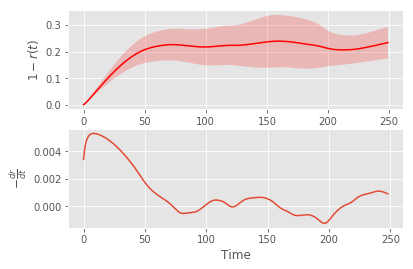

Burn-in steps: 98


In [269]:
# Brede 1 (Optimize coupling)
''' This experiment optimize a binary adjacency matrix for a *single* pattern of intrinsic frequencies.
    The number of links in the graph and the coupling strength, sigma_star, are kept constant.'''

# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
num_units = 100
num_links = 175
omega_name = 'uniform'
omega_dist, g0 = get_dist(omega_name)
sigma_star = .7
iterations = 100
transform = 'softmax'
kuramoto_steps=250
alpha=1e-1
lr=1e-2
triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)
ut_size = int(num_units * (num_units - 1) / 2)

# Testing parameters
num_phase_init = 10
sigma = np.linspace(.1, 1.6, 10)

# Determine burn-in time:
grad_thresh = 1e-5
all_cv = []
logits = torch.rand(ut_size)

connectivity = torch.zeros((1, num_units, num_units))

if transform is 'softmax':
    soft_connectivity = softmax(logits, dim=-1)
elif transform is 'sigmoid':
    soft_connectivity = sigmoid(logits)
else:
    soft_connectivity = logits
_, hard_inds = torch.topk(soft_connectivity,num_links, dim=-1)
hard_connectivity = torch.zeros_like(soft_connectivity).scatter_(0,hard_inds, torch.ones_like(hard_inds).float())
connectivity[:,triu_ind[0],triu_ind[1]] = hard_connectivity
connectivity += connectivity.transpose(2,1)

for _ in range(10):
    cvh = []
    omega = omega_dist.sample(sample_shape=torch.Size([1,num_units]))
    phase = np.pi * torch.ones(batch_size,num_units)
    for k in range(kuramoto_steps):
        phase = kuramoto_step(phase,sigma_star * connectivity, omega, alpha=alpha)
        cvh.append(circular_variance(phase.unsqueeze(0)))
    all_cv.append(torch.stack(cvh))

mean_cv = torch.stack(all_cv).mean(0).numpy()
grad_cv = np.diff(mean_cv)
std_cv = torch.stack(all_cv).std(0).numpy()

fig, axes = plt.subplots(2)
axes[0].plot(mean_cv, color='r')
axes[0].fill_between(np.arange(kuramoto_steps), mean_cv - std_cv, mean_cv + std_cv,
    alpha=0.2, facecolor='r', antialiased=True)
axes[0].set_xlabel('Time')
axes[0].set_ylabel(r'$1 - r(t)$')
axes[1].plot(np.diff(mean_cv))
axes[1].set_xlabel('Time')
axes[1].set_ylabel(r'$-\frac{dr}{dt}$')
burn_in_steps = np.argwhere(np.abs(grad_cv) < grad_thresh).min()
plt.show()
plt.close()

print('Burn-in steps: {}'.format(burn_in_steps))

In [270]:
# Brede 1: Optimize for single omega vector
np.random.seed(seed)
torch.manual_seed(seed)
omega = omega_dist.sample(sample_shape=torch.Size([1,num_units]))
print('Optimizing coupling with average degree {}'.format(2*num_links / float(num_units)))
cv_star,logits_star, connectivity_star, flow_star,co, pn = optimize_connectivity(num_units, num_links, omega,
                                                          coupling_strength=sigma_star,iterations=iterations,
                                                          alpha=alpha, lr=lr, kuramoto_steps=kuramoto_steps,
                                                          burn_in_steps=burn_in_steps, transform=transform)


Optimizing coupling with average degree 3.5


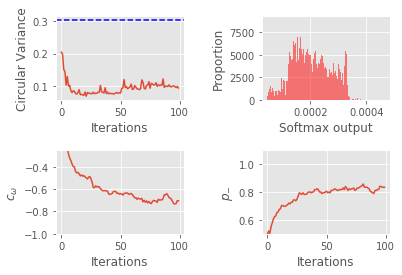

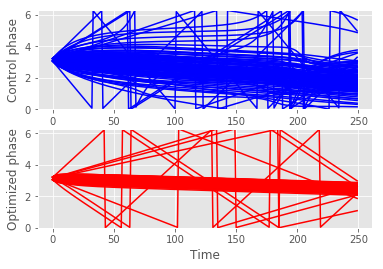

Optimized circular variance: 0.06968710571527481


In [271]:
# Brede 1: Show loss and evolved coupling probabilities
fig, axes = plt.subplots(2,2)
axes[0,0].plot(cv_star)

# Control
batch_size=1024
control_logits = torch.rand(ut_size)

control_connectivity = torch.zeros((1, num_units, num_units))
if transform is 'softmax':
    soft_connectivity = softmax(control_logits, dim=-1)
elif transform is 'sigmoid':
    soft_connectivity = sigmoid(control_logits)
else:
    soft_connectivity = control_logits
_, hard_inds = torch.topk(soft_connectivity,num_links, dim=-1)
hard_connectivity = torch.zeros_like(soft_connectivity).scatter_(0,hard_inds, torch.ones_like(hard_inds).float())
control_connectivity[:,triu_ind[0],triu_ind[1]] = hard_connectivity
control_connectivity += control_connectivity.transpose(2,1)
control_coupling = control_connectivity * sigma_star

phase = np.pi * torch.ones(batch_size,num_units)
flow = []
for k in range(kuramoto_steps):
    phase = kuramoto_step(phase, control_coupling, omega, alpha=alpha)
    flow.append(phase)
flow = torch.stack(flow).transpose(1,0)
truncated_flow = flow[:,burn_in_steps:,:]
cv_control = circular_variance(truncated_flow)
axes[0,0].axhline(y=cv_control.numpy(),color='b', linestyle='--')
axes[0,0].set_ylabel('Circular Variance')
axes[0,0].set_xlabel('Iterations')

# Plot
axes[0,1].hist(np_softmax(logits_star, axis=-1),250,color='r',alpha=.5, density=True)
axes[0,1].set_ylabel('Proportion')
axes[0,1].set_xlabel('Softmax output')

axes[1,0].plot(co)
axes[1,0].set_ylim([-1,-.25])
axes[1,0].set_ylabel(r'$c_{\omega}$')
axes[1,0].set_xlabel('Iterations')

axes[1,1].plot(pn)
axes[1,1].set_ylim([.5,1.1])
axes[1,1].set_ylabel(r'$p_{-}$')
axes[1,1].set_xlabel('Iterations')

plt.subplots_adjust(wspace=.6, hspace=.6)
plt.show()
plt.close()

fig, axes = plt.subplots(2)
flow = (flow % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
flow_star = (flow_star % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
axes[0].plot(flow[3,...],color='b')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Control phase')
axes[0].set_ylim([0,2*np.pi])
axes[1].plot(flow_star[0,...],color='r')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Optimized phase')
axes[1].set_ylim([0,2*np.pi])
plt.show()
plt.close()
print('Optimized circular variance: {}'.format(cv_star.min()))

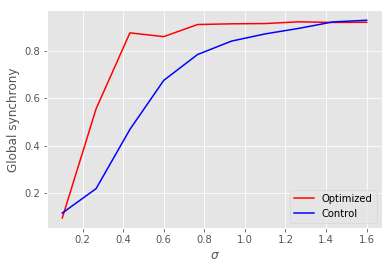

In [127]:
# Brede 1: Plot synchrony per sigma

plt.plot(sigma, 1 - np.array(R), color='r')
plt.plot(sigma, 1 - np.array(R_control), color='b')
plt.legend(('Optimized', 'Control'))
plt.xlabel(r'$\sigma$')
plt.ylabel('Global synchrony')
plt.show()
plt.close()

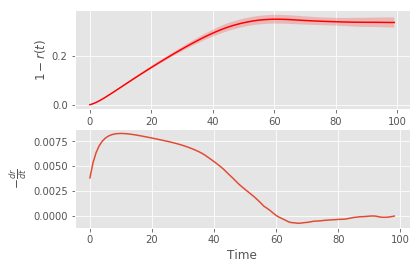

Burn-in steps: 60


In [14]:
#### Brede 2 (Coupling network)

# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
num_units = 10
num_out = int(num_units * (num_units - 1) / 2)
num_links = 18
batch_size=128
omega_name = 'uniform'
omega_dist, g0 = get_dist(omega_name)
transform='softmax'
num_hid_units= 1024
num_hid_layers = 1
sigma_star = .3
kuramoto_steps=100
iterations = 450
# TRY CHANGING T NEXT
alpha = 1e-1
lr=5e-5
ut_size = int(num_units * (num_units - 1) / 2)
T = 10
optimizer='Adam'
view_inner_opt=-1
view_lr = -1

# Testing parameters
num_omega = 10
sigma = np.linspace(.05, .8, 50)
num_phase_init = 10
triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)


# Determine burn-in time:
cn = connectivity_GRU(num_units, num_out, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers, transform=transform, T=T)
# cn = connectivity_net(num_units, num_hid_units=num_hid_units, num_hid_layers=num_hid_layers, transform=transform)
grad_thresh = 1e-4
all_cv = []

for _ in range(10):
    cvh = []
    omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
    connectivity = torch.zeros((batch_size, num_units, num_units))
    h = cn.init_hidden(batch_size)
    soft_connectivity = cn.forward(omega,h)[-1,...]
    _, hard_inds = torch.topk(soft_connectivity,num_links, dim=-1)
    ut_connectivity = torch.zeros_like(soft_connectivity).scatter_(1,hard_inds, torch.ones_like(hard_inds).float())
    connectivity[:,triu_ind[0],triu_ind[1]] = ut_connectivity
    connectivity += connectivity.transpose(2,1)
    phase = np.pi*torch.ones((batch_size, num_units))
    for k in range(kuramoto_steps):
        phase = kuramoto_step(phase,sigma_star * connectivity, omega, alpha=alpha)
        cvh.append(circular_variance(phase.unsqueeze(0)))
    all_cv.append(torch.stack(cvh))

mean_cv = torch.stack(all_cv).mean(0).numpy()
grad_cv = np.diff(mean_cv)
std_cv = torch.stack(all_cv).std(0).numpy()

fig, axes = plt.subplots(2)
axes[0].plot(mean_cv, color='r')
axes[0].fill_between(np.arange(kuramoto_steps), mean_cv - std_cv, mean_cv + std_cv,
    alpha=0.2, facecolor='r', antialiased=True)
axes[0].set_xlabel('Time')
axes[0].set_ylabel(r'$1 - r(t)$')
axes[1].plot(np.diff(mean_cv))
axes[1].set_xlabel('Time')
axes[1].set_ylabel(r'$-\frac{dr}{dt}$')
burn_in_steps = np.argwhere(np.abs(grad_cv) < grad_thresh).min()
plt.show()
plt.close()

print('Burn-in steps: {}'.format(burn_in_steps))


In [15]:
# Brede 2: Optimize coupling net
print('Optimizing coupling with average degree {}'.format(2*num_links / float(num_units)))
cv_star, cn, co, pn, oh, ioh, ah = optimize_connectivity_gru(num_units, num_out, num_links, omega_name=omega_name, batch_size=batch_size,
                                        coupling_strength=sigma_star,iterations=iterations, transform=transform,
                                        alpha=alpha, lr=lr, kuramoto_steps=kuramoto_steps,
                                        num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,
                                        burn_in_steps=burn_in_steps, T=T, optimizer=optimizer,
                                        view_inner_opt=view_inner_opt, view_lr=view_lr)

Optimizing coupling with average degree 3.6


KeyboardInterrupt: 

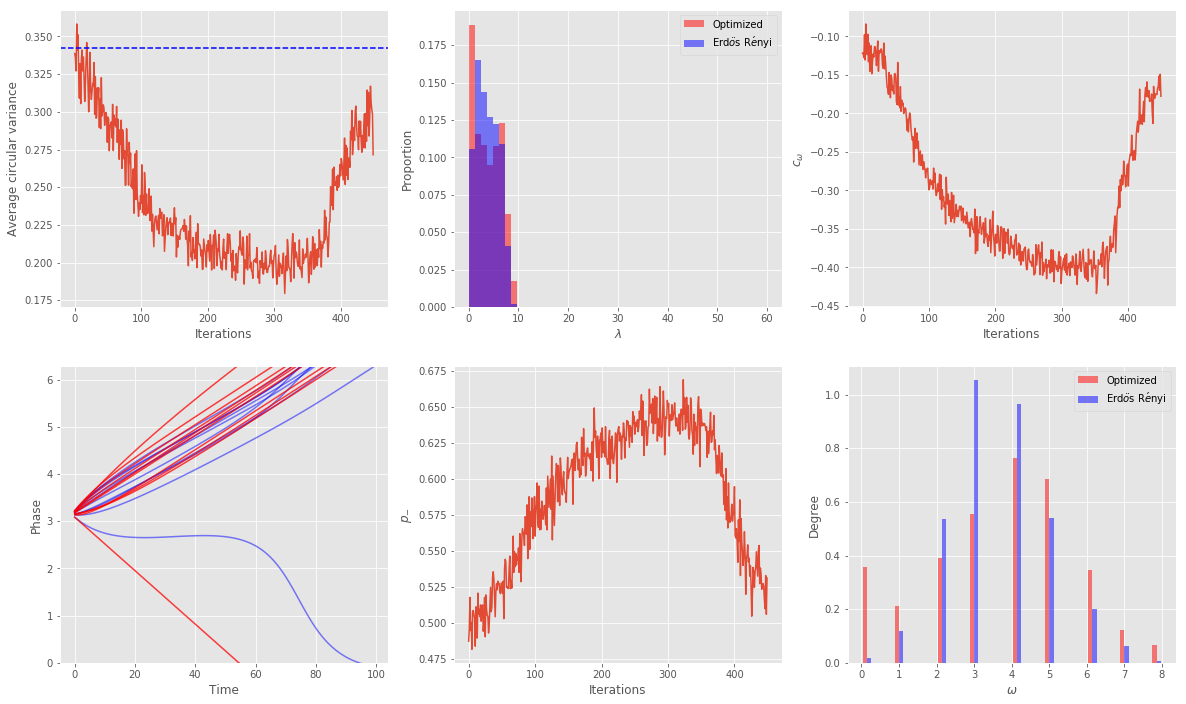

Control c.v. : 0.3426087498664856
Optimal c.v. : 0.3083270192146301


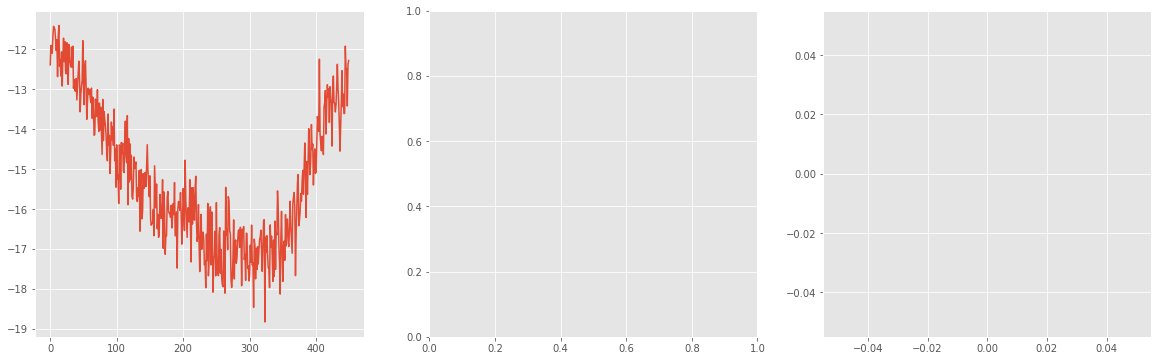

In [158]:
# Brede 2: Show loss and evolved coupling probabilities
num_ut = int(num_units * (num_units - 1) / 2)
fig, axes = plt.subplots(2,3,figsize=(20,12))
axes[0,0].plot(cv_star)
axes[0,0].set_xlabel('Iterations')
axes[0,0].set_ylabel('Average circular variance')

# Control
omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
connectivity_star = torch.zeros((batch_size,num_units,num_units))
control_connectivity = torch.zeros((batch_size,num_units, num_units))
cmx = [connectivity_star, control_connectivity]

for j, mx in enumerate(cmx):
    if j == 0: h = cn.init_hidden(batch_size)
    prob = cn.forward(omega, h)[-1,...] if j == 0 else torch.rand(batch_size, num_ut)
    _, hard_inds = torch.topk(prob,num_links, dim=-1)
    ut_connectivity = torch.zeros_like(prob).scatter_(1,hard_inds, torch.ones_like(hard_inds).float())
    cmx[j][:,triu_ind[0],triu_ind[1]] = ut_connectivity
    cmx[j] += cmx[j].transpose(2,1)          

init_phase = np.pi * torch.ones(batch_size,num_units)

# Measure loss on control
control_flow = []
phase = init_phase
for k in range(kuramoto_steps):
    phase = kuramoto_step(phase, cmx[1]*sigma_star, omega, alpha=alpha)
    control_flow.append(phase)
control_flow = torch.stack(control_flow).transpose(1,0)
truncated_control = control_flow[:,burn_in_steps:,:]
cv_control = circular_variance(truncated_control)
axes[0,0].axhline(y=cv_control.numpy(),color='b', linestyle='--')

# Measure loss on opt
opt_flow = []
phase = init_phase
for k in range(kuramoto_steps):
    phase = kuramoto_step(phase, cmx[0]*sigma_star, omega, alpha=alpha)
    opt_flow.append(phase)
opt_flow = torch.stack(opt_flow).transpose(1,0)
truncated_opt = opt_flow[:,burn_in_steps:,:]
cv_opt = circular_variance(truncated_opt)

evals = []
evals_control = []
D = cmx[0].sum(1).numpy().reshape(-1)
D_control = cmx[1].sum(1).numpy().reshape(-1)

lp = laplacian(cmx[0])
lp_control = laplacian(cmx[1])

for b in range(batch_size):
    evl_control, _ = torch.eig(lp_control[b,...])
    evl, _ = torch.eig(lp[b,...])
    evals.append(evl[:,0].numpy())
    evals_control.append(evl_control[:,0].numpy())

bins = np.linspace(0,60,50)
axes[0,1].hist(np.array(evals).reshape(-1), bins=bins, color='r',alpha=.5, density=True)
axes[0,1].hist(np.array(evals_control).reshape(-1), bins=bins, color='b',alpha=.5, density=True)
axes[0,1].set_xlabel(r'$\lambda$')
axes[0,1].set_ylabel('Proportion')
axes[0,1].legend(('Optimized', r'Erd$\"{o}$s R$\'{e}$nyi'))
#axes[1].set_ylim([0,.25])

axes[0,2].plot(np.array(co).reshape(-1))
axes[0,2].set_ylabel(r'$c_{\omega}$')
axes[0,2].set_xlabel('Iterations')


axes[1,0].plot(control_flow[0,...].numpy(), color='b', alpha=.5)
axes[1,0].plot(opt_flow[0,...].numpy(), color='r', alpha=.75)
axes[1,0].set_ylim([0,2*np.pi])
axes[1,0].set_xlabel('Time')
axes[1,0].set_ylabel('Phase')


axes[1,1].plot(np.array(pn))
axes[1,1].set_ylabel(r'$p_{-}$')
axes[1,1].set_xlabel('Iterations')

all_D = np.array([D, D_control]).transpose()
axes[1,2].hist(all_D,28,color=('r','b'),alpha=.5,histtype='bar',density=True)
# axes[1,2].scatter(omega[0,...].reshape(-1), D_control[0,...].reshape(-1), color='b', alpha=.25)
# axes[1,2].scatter(omega[0,...].reshape(-1), D[0,...].reshape(-1), color='r', alpha=.25)
axes[1,2].set_xlabel(r'$\omega$')
axes[1,2].set_ylabel('Degree')
axes[1,2].legend(('Optimized', r'Erd$\"{o}$s R$\'{e}$nyi'))

plt.show()
plt.close()

print('Control c.v. : {}'.format(cv_control.numpy()))
print('Optimal c.v. : {}'.format(cv_opt.numpy()))

hsv = plt.get_cmap('hsv')
fig, axes = plt.subplots(1,3,figsize=(20,6))
axes[0].plot(oh)
alphas = np.linspace(.05, 1.0, len(ioh))
for i in range(len(ioh)):
    alpha = alphas[i]
    axes[1].plot(ioh[i], color='r', alpha=alpha)
# colors = hsv(np.linspace(0, 1.0, ah.shape[-1]))
axes[2].plot(ah)
plt.show()
plt.close()


In [241]:
# For multiple phase initializations, compute circular variance of optimized net vs random

sigma = np.linspace(0.0, 1.0, 20)
# For each random intrinsic frequency sample
omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
r_s_mean = []
r_s_control_mean = []
r_s_std = []
r_s_control_std = []

# For each coupling strength
for sig in sigma:

    r_p = []
    r_p_control = []

    # Coupling values: opt vs random

    # Initialize coupling matrices
    connectivity_star = torch.zeros((batch_size,num_units,num_units))
    control_connectivity = torch.zeros((batch_size,num_units,num_units))
    cmx = [connectivity_star, control_connectivity]
    h = cn.init_hidden(batch_size)
    for j, mx in enumerate(cmx):
        prob = cn.forward(omega, h)[-1] if j == 0 else torch.rand(batch_size, num_ut)
        _, hard_inds = torch.topk(prob,num_links, dim=-1)
        ut_connectivity = torch.zeros_like(prob).scatter_(1,hard_inds, torch.ones_like(hard_inds).float())
        cmx[j][:,triu_ind[0],triu_ind[1]] = ut_connectivity
        cmx[j] += cmx[j].transpose(2,1)    

#         init_phase = np.pi*torch.ones((1,num_units))
    init_phase = 2*np.pi*torch.rand((1,num_units))
    # For each random phase initialization
    for p in range(num_phase_init):
        # Measure loss on control
        control_flow = []
        phase = init_phase
        for k in range(kuramoto_steps):
            phase = kuramoto_step(phase, cmx[1]*sig, omega, alpha=alpha)
            control_flow.append(phase)
        control_flow = torch.stack(control_flow).transpose(1,0)
        truncated_control = control_flow[:,burn_in_steps:,:]
        cv_control = circular_variance(truncated_control)

        # Measure loss on opt
        opt_flow = []
        phase = init_phase
        for k in range(kuramoto_steps):
            phase = kuramoto_step(phase, cmx[0]*sig, omega, alpha=alpha)
            opt_flow.append(phase)
        opt_flow = torch.stack(opt_flow).transpose(1,0)
        truncated_opt = opt_flow[:,burn_in_steps:,:]
        cv_opt = circular_variance(truncated_opt)

        r_p.append(cv_opt)
        r_p_control.append(cv_control)
    # Average over initializations for this sigma
    r_s_mean.append(np.mean(r_p))
    r_s_control_mean.append(np.mean(r_p_control))
    r_s_std.append(np.std(r_p))
    r_s_control_std.append(np.std(r_p_control))

# R averaged over omega

R = np.array(r_s_mean)
R_err = np.array(r_s_std)
R_control = np.array(r_s_control_mean)
R_control_err = np.array(r_s_control_std)

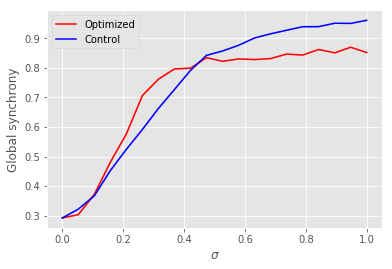

In [242]:
# Brede 2: Plot synchrony per sigma averaged over omega
synchrony = 1 - np.array(R)
synchrony_control = 1 - np.array(R_control)
plt.plot(sigma, synchrony, color='r')
plt.fill_between(sigma, synchrony-R_err, synchrony+R_err,
    alpha=0.2, edgecolor='r', facecolor='r',antialiased=True)
plt.plot(sigma, 1 - np.array(R_control), color='b')
plt.fill_between(sigma, synchrony_control-R_control_err, synchrony_control+R_control_err,
    alpha=0.2, edgecolor='b', facecolor='b',antialiased=True)
plt.legend(('Optimized', 'Control'))
plt.xlabel(r'$\sigma$')
plt.ylabel('Global synchrony')
plt.show()
plt.close()

In [47]:
# Optimize coupling function
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

# Training parameters

omega_name = 'uniform'
num_units = 17

num_iterations = 100
sigma_star = .7
O = 1.0
kuramoto_steps = 250
alpha=1e-2
num_out = int(num_units * (num_units - 1) / 2)
num_hid_units=1024
num_hid_layers = 1
batch_size = 128
lr = 1e-3
LossFunc=circular_variance
transform= 'sigmoid'
recurrent = True
T=10
burn_in_prop = .5
burn_in_steps = int(burn_in_prop * kuramoto_steps)

# Training Loop
omega_dist, g0 = get_dist(omega_name)
lh = []
if recurrent:
    cn = connectivity_GRU(num_units, num_out, num_hid_units=num_hid_units, num_hid_layers = num_hid_layers, transform=transform, T=T)
else:   
    cn = connectivity_net(num_units,num_out, num_hid_units=num_hid_units, num_hid_layers = num_hid_layers, transform=transform)
opt = torch.optim.Adam(cn.parameters(),lr=lr)
triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)
# col = np.zeros(num_units)
# col[1::num_units - 2] = 1.0
# connectivity = torch.tensor(circulant(col))
# connectivity = torch.stack([connectivity for _ in range(batch_size)]).float()

for i in range(num_iterations):
    opt.zero_grad()
    omega = O*omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))

    if recurrent:
        h = cn.init_hidden(batch_size)
        soft_connectivity = cn(omega, h)
    else:
        soft_connectivity = cn(omega)
    connectivity = torch.zeros((batch_size, num_units, num_units))
    tmp_connectivity = torch.zeros((batch_size, num_units, num_units))
    tmp_connectivity[:,triu_ind[0], triu_ind[1]] = soft_connectivity
    _, hard_inds = torch.topk(tmp_connectivity,1, dim=-1)

    hard = torch.zeros((batch_size, num_units)).scatter_(-1, hard_inds, omega)
    new_omega = hard_ranked - soft_ranked.detach() + soft_ranked
    phase = np.pi * torch.ones((batch_size, num_units))
    flow = []
    for k in range(kuramoto_steps):
            phase = kuramoto_step(phase, sigma_star*connectivity, new_omega, alpha=alpha)
            flow.append(phase)
    flow = torch.stack(flow).transpose(1,0)
    truncated_flow = flow[:,burn_in_steps:,:]
    cv = circular_variance(truncated_flow)
    lh.append(cv.mean().detach().numpy())
    cv.backward()
    opt.step()

> <ipython-input-47-feff86a8d203>(52)<module>()
     51     ipdb.set_trace()
---> 52     hard_connectivity = torch.zeros((batch_size, num_units, num_units))
     53     soft_connectivity = torch.zeros((batch_size, num_units, num_units))

ipdb> ut.shape
torch.Size([128, 45])
ipdb> n
> <ipython-input-47-feff86a8d203>(53)<module>()
     52     hard_connectivity = torch.zeros((batch_size, num_units, num_units))
---> 53     soft_connectivity = torch.zeros((batch_size, num_units, num_units))
     54     soft_connectivity[:,triu_ind[0], triu_ind[1]] = ut

ipdb> n
> <ipython-input-47-feff86a8d203>(54)<module>()
     53     soft_connectivity = torch.zeros((batch_size, num_units, num_units))
---> 54     soft_connectivity[:,triu_ind[0], triu_ind[1]] = ut
     55     _, hard_inds = torch.topk(soft_connectivity,1, dim=-1)

ipdb> n
> <ipython-input-47-feff86a8d203>(55)<module>()
     54     soft_connectivity[:,triu_ind[0], triu_ind[1]] = ut
---> 55     _, hard_inds = torch.topk(soft_connectivity,1, 

BdbQuit: 

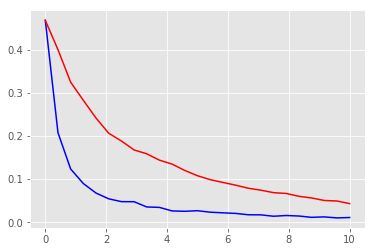

In [45]:
plt.plot(sigmas, both_lh[0], color='b')
plt.plot(sigmas, both_lh[1], color='r')
plt.show()
plt.close()

In [117]:
#### Brede 3 (Coupling cGRU)

# Training parameters
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
num_units = 100
num_out = int(num_units * (num_units - 1) / 2)
num_links = 175
batch_size=128
omega_name = 'uniform'
omega_dist, g0 = get_dist(omega_name)
transform='softmax'
num_hid_units= 1024
num_hid_layers = 1
sigma_star = .7
kuramoto_steps=25
GRU_steps=1
burn_in_steps=15
iterations = 50
# TRY CHANGING T NEXT
alpha = 1e-1
lr=1e-5
ut_size = int(num_units * (num_units - 1) / 2)
optimizer='Adam'
view_inner_opt=-1
view_lr = -1
feedback=False

# Testing parameters
num_omega = 10
sigma = np.linspace(.05, .8, 50)
num_phase_init = 10
triu_ind = torch.triu_indices(row=num_units, col=num_units, offset=1)

In [120]:
# Brede 3: Optimize cGRU
print('Optimizing coupling with average degree {}'.format(2*num_links / float(num_units)))
cv_star, cn,connectivities = optimize_connectivity_cgru(num_units, num_out, num_links, omega_name=omega_name, batch_size=batch_size,
                                        coupling_strength=sigma_star,iterations=iterations, transform=transform,
                                        alpha=alpha, lr=lr, kuramoto_steps=kuramoto_steps,
                                        num_hid_units=num_hid_units, num_hid_layers=num_hid_layers,
                                        burn_in_steps=burn_in_steps,optimizer=optimizer,
                                        view_inner_opt=view_inner_opt, view_lr=view_lr,
                                        GRU_steps=GRU_steps, feedback=feedback, verbose=1)

Optimizing coupling with average degree 3.5
Iteration 0. Loss: 0.1057518720626831. Time/batch: 1.0531554222106934
Iteration 1. Loss: 0.10607536137104034. Time/batch: 0.8460235595703125
Iteration 2. Loss: 0.10618655383586884. Time/batch: 0.9371469020843506
Iteration 3. Loss: 0.10621390491724014. Time/batch: 0.9894418716430664
Iteration 4. Loss: 0.10485787689685822. Time/batch: 1.2113044261932373
Iteration 5. Loss: 0.10460396856069565. Time/batch: 0.9048659801483154
Iteration 6. Loss: 0.10522810369729996. Time/batch: 0.850775957107544
Iteration 7. Loss: 0.10382306575775146. Time/batch: 0.7666151523590088
Iteration 8. Loss: 0.10014816373586655. Time/batch: 0.947995662689209
Iteration 9. Loss: 0.10253943502902985. Time/batch: 1.04664945602417
Iteration 10. Loss: 0.10527946799993515. Time/batch: 0.8642315864562988
Iteration 11. Loss: 0.10617116838693619. Time/batch: 0.9756073951721191
Iteration 12. Loss: 0.10284692049026489. Time/batch: 0.8932151794433594
Iteration 13. Loss: 0.1056721806526

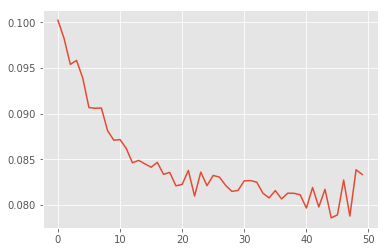

Minimum loss: 0.07858464121818542


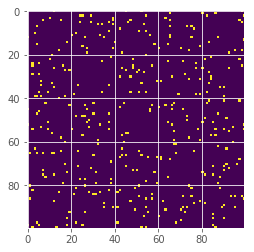

In [115]:
plt.plot(cv_star)
plt.show()
plt.close()
print('Minimum loss: {}'.format(np.array(cv_star).min()))

# # # Measure loss on opt
# omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
# h = cn.init_hidden(batch_size)
# init_phase = np.pi * torch.ones(batch_size,num_units)
# flow, connectivities = cn.forward(omega, h, init_phase, kuramoto_steps=100, return_connectivities=True)
# flow=torch.stack(flow)[:,0,...].detach().numpy()
# plt.plot(flow,color='r',alpha=.5)
# plt.show()
# plt.close()

# if feedback:
fig, ax = plt.subplots()
tmp_connectivities = torch.stack(connectivities)[:,0,...].detach().numpy()
im = plt.imshow(tmp_connectivities[0,...])
animate = lambda i: im.set_array(tmp_connectivities[i,...])
ani = animation.FuncAnimation(fig, animate, frames=kuramoto_steps)
HTML(ani.to_html5_video())

In [122]:
ff_cv = cv_star

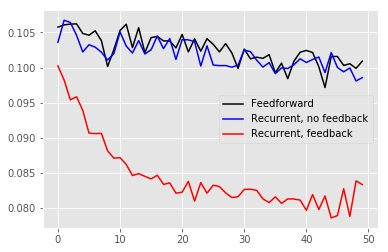

In [125]:
plt.plot(ff_cv, color='k')
plt.plot(nof_cv, color='b')
plt.plot(feedback_cv, color='r')
plt.legend(('Feedforward', 'Recurrent, no feedback', 'Recurrent, feedback'))
plt.show()
plt.close()